In [84]:
! pip install transformers
! pip install keras_tuner

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [85]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [86]:
!echo $CUDA_VISIBLE_DEVICES

1


In [87]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPool1D, concatenate, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import GridSearch
from keras_tuner import HyperModel, Objective
from keras import regularizers
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [88]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available: ", gpus)

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [89]:
if gpus:
    # Assuming you want to use the first GPU if available
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [90]:
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Memory growth enabled


In [91]:
import keras
SEED = 42
tf.random.set_seed(SEED)

DATASET PROCESSATO

In [92]:
choice = 'umberto' #umberto

In [94]:
max_length = 0
if choice == 'alberto':
    training_data = pd.read_csv('../Evalita2023/alberto_preprocessing_training_textual_haspeede2.csv')
    test_data = pd.read_csv('../Evalita2023/alberto_preprocessing/alberto_preprocessing_test_textual.csv')
    max_length = 290
    print('alberto chosen')
else:
    training_data = pd.read_csv('../Evalita2023/umberto_preprocessing_training_textual_haspeede2.csv')
    test_data = pd.read_csv('../Evalita2023/umberto_preprocessing/umberto_preprocessing_test_textual.csv')
    max_length = 357
    print('umberto chosen')

print(max_length)

umberto chosen
357


In [95]:
training_data

,anonymized_text,label
0,[user] con tutte le denunce che si sta beccand...,1
1,[hashtag] prescrizione [/hashtag] i t re magi ...,0
2,il [hashtag] movimento cinque stelle [/hashtag...,1
3,la [hashtag] lega [/hashtag] e il [hashtag] mo...,0
4,che cosa cambia questa [hashtag] legge [/hasht...,0
...,...,...
12432,gli stati nazionali devono essere pronti a rin...,0
12433,il ministro dell interno della germania [hasht...,0
12434,[hashtag] salvini [/hashtag] in italia troppi ...,0
12435,[user] [user] chi giubila in buona fede non ha...,0


In [96]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12437 entries, 0 to 12436
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   anonymized_text  12437 non-null  object
 1   label            12437 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 194.5+ KB


In [97]:
test_data

,anonymized_tweet_id,anonymized_text,label,dataset
0,424801448454884,questo anno [hashtag] babbo natale [/hashtag] ...,1,test_politics
1,775194088981616,adesso che in mezzo alla strada grazie al verg...,1,test_politics
2,386928936347190,circondatevi di persone che non sono diventate...,0,test_politics
3,957546674360002,seriamente per capire se un ladro mi entra in ...,0,test_politics
4,530526299555950,che poi è probabile che [hashtag] spataro [/ha...,0,test_politics
...,...,...,...,...
4395,391599381944152,[user] esatto brava ti dico di piu i nazisti n...,0,test_religious
4396,974317501584882,[user] togliere la parola non vaccinati e mett...,0,test_religious
4397,739414582677163,[user] [user] lo sai o no che i musulmani rico...,0,test_religious
4398,470933865054049,berlino memoriale per gli ebrei assassinati d ...,0,test_religious


In [98]:
test_data['dataset'].unique()

array(['test_politics', 'test_religious'], dtype=object)

### only for Task B

In [99]:
test_religious_data = test_data.loc[test_data['dataset'] == 'test_religious']
test_politics_data = test_data.loc[test_data['dataset'] == 'test_politics']

In [100]:
test_religious_data

,anonymized_tweet_id,anonymized_text,label,dataset
605,379748472796095,voglio abituare tutti gli abitanti del luogo e...,0,test_religious
606,195027074607893,l europa laica e comunista esce allo scoperto ...,0,test_religious
607,97213378242080,[user] gli ebrei insieme ai liberali e altre c...,0,test_religious
608,894894959501945,[user] la mussulmana lombarda per portarla a c...,1,test_religious
609,439618972593653,denunciare coloro che vogliono limitare le lib...,0,test_religious
...,...,...,...,...
4395,391599381944152,[user] esatto brava ti dico di piu i nazisti n...,0,test_religious
4396,974317501584882,[user] togliere la parola non vaccinati e mett...,0,test_religious
4397,739414582677163,[user] [user] lo sai o no che i musulmani rico...,0,test_religious
4398,470933865054049,berlino memoriale per gli ebrei assassinati d ...,0,test_religious


In [102]:
# Load model directly
from transformers import AutoTokenizer

#max_length = 300

tokenizer = AutoTokenizer.from_pretrained("idb-ita/gilberto-uncased-from-camembert")

def tokenize_function(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=max_length,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


## Train-Test Split + Tweets transformation for the model

In [103]:
from sklearn.model_selection import train_test_split

labels = training_data['label']

X_train, X_val, y_train, y_val = train_test_split(training_data, labels, test_size=0.20, random_state=SEED, stratify=labels)

In [104]:
X_train.head()

,anonymized_text,label
1777,[hashtag] decreto cura italia [/hashtag] [hash...,0
216,il premier [hashtag] conte [/hashtag] ha appen...,0
4524,[hashtag] salvini pagliaccio [/hashtag] cosa n...,1
5452,il [hashtag] movimento cinque stelle [/hashtag...,0
5742,vaticano contro trump appello alla chiesa usa ...,0


In [105]:
def dumb_fun(Xmask):
    num_ones = np.count_nonzero(Xmask[i,:] == 1)
    if num_ones >= 260:
        print(Xmask[i,:])
        print(f"The number of ones in the ndarray is: {num_ones}")

In [106]:
X_train.head()

,anonymized_text,label
1777,[hashtag] decreto cura italia [/hashtag] [hash...,0
216,il premier [hashtag] conte [/hashtag] ha appen...,0
4524,[hashtag] salvini pagliaccio [/hashtag] cosa n...,1
5452,il [hashtag] movimento cinque stelle [/hashtag...,0
5742,vaticano contro trump appello alla chiesa usa ...,0


In [107]:
X_val.head()

,anonymized_text,label
5481,[user] [user] potreste segnalare a [hashtag] d...,0
2900,gli [hashtag] animali [/hashtag] [hashtag] dom...,0
5296,[user] è un vizio dei mattei [hashtag] renzi [...,1
6843,eh si anche lui niente obiettivo magistrati tu...,0
10874,[hashtag] roma [/hashtag] [number] [number] en...,1


In [108]:
test_data.head()

,anonymized_tweet_id,anonymized_text,label,dataset
0,424801448454884,questo anno [hashtag] babbo natale [/hashtag] ...,1,test_politics
1,775194088981616,adesso che in mezzo alla strada grazie al verg...,1,test_politics
2,386928936347190,circondatevi di persone che non sono diventate...,0,test_politics
3,957546674360002,seriamente per capire se un ladro mi entra in ...,0,test_politics
4,530526299555950,che poi è probabile che [hashtag] spataro [/ha...,0,test_politics


In [109]:
# initialize two arrays for input tensors
Xids = np.zeros((len(X_train['anonymized_text']), max_length))
Xmask = np.zeros((len(X_train['anonymized_text']), max_length))

for i, sentence in enumerate(X_train['anonymized_text']):
    Xids[i, :], Xmask[i, :] = tokenize_function(sentence)
labels = y_train
BATCH_SIZE = 128  # we will use batches of 128

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

print(dataset)

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# batch data
dataset = dataset.batch(BATCH_SIZE)
train = dataset
del dataset

<TensorSliceDataset shapes: ((357,), (357,), ()), types: (tf.float64, tf.float64, tf.int64)>


In [110]:
#print(tokenizer.convert_ids_to_tokens(Xids[0,:]))

In [111]:
"""tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")

phrase = " <hashtag> movimento cinque stelle </hashtag>"
phrase1 = " <number> salvini a casa"
    #X_train[X_train['anonymized_text'].str.contains(r'.*[0-9].*', regex=True)]['anonymized_text'][5186]

Xids[i, :], Xmask[i, :] = tokenize_function(phrase, phrase1)

print(tokenizer.convert_ids_to_tokens(Xids[0,:]))"""

'tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")\n\nphrase = " <hashtag> movimento cinque stelle </hashtag>"\nphrase1 = " <number> salvini a casa"\n    #X_train[X_train[\'anonymized_text\'].str.contains(r\'.*[0-9].*\', regex=True)][\'anonymized_text\'][5186]\n\nXids[i, :], Xmask[i, :] = tokenize_function(phrase, phrase1)\n\nprint(tokenizer.convert_ids_to_tokens(Xids[0,:]))'

In [112]:
"""tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")

phrase = "[hashtag] [/hashtag] [url] [email] [percent] [money] [phone] [user] [time] [url] [date] [number] [allcaps] ciao! [/allcaps] m[number]s"

Xids[i, :], Xmask[i, :] = tokenize_function(phrase)

print(tokenizer.convert_ids_to_tokens(Xids[i,:]))"""

'tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")\n\nphrase = "[hashtag] [/hashtag] [url] [email] [percent] [money] [phone] [user] [time] [url] [date] [number] [allcaps] ciao! [/allcaps] m[number]s"\n\nXids[i, :], Xmask[i, :] = tokenize_function(phrase)\n\nprint(tokenizer.convert_ids_to_tokens(Xids[i,:]))'

In [113]:
XidsVal = np.zeros((len(X_val['anonymized_text']), max_length))
XmaskVal = np.zeros((len(X_val['anonymized_text']), max_length))

for i, sentence in enumerate(X_val['anonymized_text']):
    XidsVal[i, :], XmaskVal[i, :] = tokenize_function(sentence)

labels_val = y_val

dataset = tf.data.Dataset.from_tensor_slices((XidsVal, XmaskVal, labels_val))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
validation = dataset
del dataset

In [114]:
XidsTestPolitics = np.zeros((len(test_politics_data['anonymized_text']), max_length))
XmaskTestPolitics = np.zeros((len(test_politics_data['anonymized_text']), max_length))

for i, sentence in enumerate(test_politics_data['anonymized_text']):
    XidsTestPolitics[i, :], XmaskTestPolitics[i, :] = tokenize_function(sentence)

labelsTPolitics = test_politics_data['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTestPolitics, XmaskTestPolitics, labelsTPolitics))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test_politics = dataset

del dataset  # delete dataset to free up disk-space

In [115]:
XidsTestReligious = np.zeros((len(test_religious_data['anonymized_text']), max_length))
XmaskTestReligious = np.zeros((len(test_religious_data['anonymized_text']), max_length))

for i, sentence in enumerate(test_religious_data['anonymized_text']):
    XidsTestReligious[i, :], XmaskTestReligious[i, :] = tokenize_function(sentence)

labelsTReligious = test_religious_data['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTestReligious, XmaskTestReligious, labelsTReligious))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test_religious = dataset

del dataset  # delete dataset to free up disk-space

## Model Training/Validation/Testing

In [116]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [117]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [118]:
from transformers import TFAutoModel
embed_dim = 768  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = TFAutoModel.from_pretrained("idb-ita/gilberto-uncased-from-camembert", from_pt=True) #m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 #Musixmatch/umberto-commoncrawl-cased-v1

        input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
        mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
        
        # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
        embeddings = model(input_ids, attention_mask=mask)[0]

        #X = TransformerBlock(embed_dim=embed_dim,num_heads=num_heads, ff_dim=ff_dim)(embeddings)
        X = Bidirectional(LSTM(units=hp.Choice('LSTM_units', values=[128]), recurrent_dropout=hp.Choice('LSTM_recurrent_dropout', values=[0.0,0.3]), return_sequences= True))(embeddings)
        X = GlobalMaxPool1D()(X)
        X = Dropout(rate=hp.Choice('rate_dropout', values=[0.6, 0.7]))(X)
        #X = BatchNormalization()(X)
        X = Dense(units=hp.Choice('dense_units', values=[16,32,64]),kernel_regularizer=regularizers.L2(hp.Choice('reg_value', [0.0,0.01,0.001])), activation="relu")(X)
        y = Dense(1, activation='sigmoid', name='outputs')(X)

        # define input and output layers of our model
        best_model = Model(inputs=[input_ids, mask], outputs=y)

        # freeze the BERT layer - otherwise we will be training 100M+ parameters...
        best_model.layers[2].trainable = False

        best_model.compile(optimizer=Adam(learning_rate = hp.Choice('learning_rate', values=[0.01, 1e-3]), clipnorm= hp.Choice('clip_norm', values= [1,3])), loss="binary_crossentropy", metrics=[F1Score()])
        return best_model

In [119]:
tuner = GridSearch(
    hypermodel = MyHyperModel(),
    objective = Objective('val_loss', 'min'),
    max_trials = 20,
    seed = SEED,
    executions_per_trial = 1,
    overwrite = False,
    project_name = "gilberto128taskB")

Reloading Tuner from ./gilberto128taskB/tuner0.json


In [120]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 7
LSTM_units (Choice)
{'default': 128, 'conditions': [], 'values': [128], 'ordered': True}
LSTM_recurrent_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3], 'ordered': True}
rate_dropout (Choice)
{'default': 0.6, 'conditions': [], 'values': [0.6, 0.7], 'ordered': True}
dense_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
reg_value (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.001], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
clip_norm (Choice)
{'default': 1, 'conditions': [], 'values': [1, 3], 'ordered': True}


In [121]:
es = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True, verbose=1)
tuner.search(train, epochs=15, validation_data=validation, callbacks=[es])

In [122]:
# Random Search 10 best results
tuner.results_summary()

Results summary
Results in ./gilberto128taskB
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
LSTM_units: 128
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.0
learning_rate: 0.001
clip_norm: 3
Score: 0.46712541580200195

Trial 06 summary
Hyperparameters:
LSTM_units: 128
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.01
learning_rate: 0.001
clip_norm: 1
Score: 0.4762532413005829

Trial 02 summary
Hyperparameters:
LSTM_units: 128
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.0
learning_rate: 0.001
clip_norm: 1
Score: 0.4799215793609619

Trial 07 summary
Hyperparameters:
LSTM_units: 128
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.01
learning_rate: 0.001
clip_norm: 3
Score: 0.48338574171066284

Trial 04 summary
Hyperparameters:
LSTM_units: 128
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.01
le

In [123]:
# Focus on Best Trial
tuner.oracle.get_best_trials()[0].get_state()

{'trial_id': '03',
 'hyperparameters': {'space': [{'class_name': 'Choice',
    'config': {'name': 'LSTM_units',
     'default': 128,
     'conditions': [],
     'values': [128],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'LSTM_recurrent_dropout',
     'default': 0.0,
     'conditions': [],
     'values': [0.0, 0.3],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'rate_dropout',
     'default': 0.6,
     'conditions': [],
     'values': [0.6, 0.7],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'dense_units',
     'default': 16,
     'conditions': [],
     'values': [16, 32, 64],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'reg_value',
     'default': 0.0,
     'conditions': [],
     'values': [0.0, 0.01, 0.001],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'learning_rate',
     'default': 0.01,
     'conditions': [],
     'values': [0.01, 

In [124]:
# Focus on Best Trial
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'LSTM_units': 128,
 'LSTM_recurrent_dropout': 0.0,
 'rate_dropout': 0.6,
 'dense_units': 16,
 'reg_value': 0.0,
 'learning_rate': 0.001,
 'clip_norm': 3}

In [125]:
# Best Model
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 357)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 357)]        0                                            
__________________________________________________________________________________________________
tf_camembert_model (TFCamembert TFBaseModelOutputWit 110621952   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 357, 256)     918528      tf_camembert_model[0][0]   

In [126]:
# Training of best model
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = best_model.fit(train, batch_size=BATCH_SIZE, epochs=60, callbacks=es, validation_data=validation)

Epoch 1/60


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


78/78 [==============================] - ETA: 0s - loss: 0.6767 - f1_score: 0.2091

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


78/78 [==============================] - 232s 3s/step - loss: 0.6767 - f1_score: 0.2091 - val_loss: 0.6441 - val_f1_score: 0.1595
Epoch 2/60
78/78 [==============================] - 194s 2s/step - loss: 0.6334 - f1_score: 0.4203 - val_loss: 0.6285 - val_f1_score: 0.6154
Epoch 3/60
78/78 [==============================] - 194s 2s/step - loss: 0.6123 - f1_score: 0.5168 - val_loss: 0.5974 - val_f1_score: 0.6308
Epoch 4/60
78/78 [==============================] - 194s 2s/step - loss: 0.5826 - f1_score: 0.5665 - val_loss: 0.5665 - val_f1_score: 0.6620
Epoch 5/60
78/78 [==============================] - 193s 2s/step - loss: 0.5468 - f1_score: 0.6159 - val_loss: 0.5371 - val_f1_score: 0.6852
Epoch 6/60
78/78 [==============================] - 193s 2s/step - loss: 0.5242 - f1_score: 0.6289 - val_loss: 0.5251 - val_f1_score: 0.7004
Epoch 7/60
78/78 [==============================] - 194s 2s/step - loss: 0.5112 - f1_score: 0.6529 - val_loss: 0.5093 - val_f1_score: 0.7014
Epoch 8/60
78/78 [======

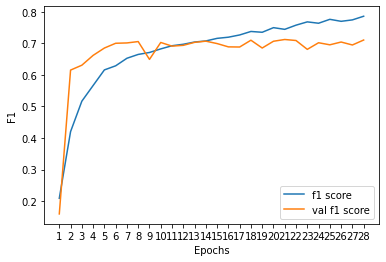

In [127]:
#F1-score plot
plt.plot(history.history["f1_score"], label='f1 score')
plt.plot(history.history["val_f1_score"], label='val f1 score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.ylim()
plt.xticks(np.arange(len(history.history["val_f1_score"])), np.arange(1, len(history.history["val_f1_score"])+1))
plt.legend(loc = 'lower right')

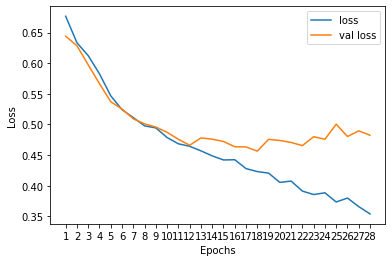

In [128]:
#Loss plot
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim()
plt.xticks(np.arange(len(history.history["loss"])), np.arange(1, len(history.history["loss"])+1))
plt.xticks(np.arange(len(history.history["val_loss"])), np.arange(1, len(history.history["val_loss"])+1))
plt.legend(loc = 'upper right')

In [129]:
pred_politics = best_model.predict(test_politics) > 0.5

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [130]:
# Getting the Classification Report
print(classification_report(list(labelsTPolitics), pred_politics, digits=4))

              precision    recall  f1-score   support

           0     0.7937    0.9400    0.8607       700
           1     0.9264    0.7557    0.8324       700

    accuracy                         0.8479      1400
   macro avg     0.8601    0.8479    0.8466      1400
weighted avg     0.8601    0.8479    0.8466      1400



In [131]:
pred_religious = best_model.predict(test_religious) > 0.5

In [132]:
# Getting the Classification Report
print(classification_report(list(labelsTReligious), pred_religious, digits=4))

              precision    recall  f1-score   support

           0     0.8701    0.7648    0.8141      2513
           1     0.2528    0.4107    0.3130       487

    accuracy                         0.7073      3000
   macro avg     0.5615    0.5878    0.5635      3000
weighted avg     0.7699    0.7073    0.7327      3000

